In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from sklearn.cluster import KMeans
from scipy import ndimage

In [4]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [2]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

In [3]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

In [5]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [6]:
def create_model(img,gt,n_cluster,patch_size):
    
    # Extract patches from input images
    img_patches = img_crop(img, patch_size, patch_size)
    gt_patches = img_crop(gt, patch_size, patch_size)
    
    # Compute features for each image patch
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

    # Create X and Y
    Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
    X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
    
    model = KMeans(n_clusters=n_cluster, random_state=2, init = 'k-means++', n_init = 20).fit(X)
    
    labels = model.labels_
    clusters_total = np.zeros(n_cluster)
    tot = np.zeros(n_cluster)
    for i in range(len(labels)):
        clusters_total[labels[i]] = clusters_total[labels[i]] + Y[i] 
        tot[labels[i]] = tot[labels[i]] + 1
        
    clusters_label = 1*(np.divide(clusters_total,tot)>=0.3)
        
    return model,clusters_label

In [7]:
def assign_label(patch,models):
    X = np.asarray(extract_features(patch)).reshape(1,-1)
    list_label=[]
    for model in models:
        cluster_chosen = model[0].predict(X)
        list_label.append(model[1][cluster_chosen])
    
    label = 1*(np.mean(list_label)>=0.3)
    
    return label

In [8]:
def calcul_F1(Y, label):    
    TN = 0
    FP = 0
    FN = 0
    TP = 0
    matrix = []
    

    for i in range(len(Y)):
        if (Y[i]==0) & (label[i]==0):
            TN = TN + 1
        elif (Y[i]==1) & (label[i]==0):
            FN = FN + 1   
        elif (Y[i]==1) & (label[i]==1):
            TP = TP + 1  
        else:
            FP = FP + 1
    
    F1_score = 0
    if (TP+FP > 0) and (TP+FN > 0):
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        F1_score = 2*precision*recall / (precision+recall)
    else:
        print('Something goes wrong...')
    
    return F1_score

In [9]:
def calculate_accuracy(img,gt,models):
    
    # Extract patches from input images
    img_patches = img_crop(img, patch_size, patch_size)
    gt_patches = img_crop(gt, patch_size, patch_size)

    # Create X and Y
    Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
    label = ([assign_label(img_patches[i],models) for i in range(len(img_patches))])
    
    # Calculate F1 score
    F1 = calcul_F1(Y, label)
    return F1,label 

In [10]:
def rotation(orig, gts):
    ks=[90,180,270]
    rotated=[ndimage.rotate(img,k) for img in orig for k in ks]
    gt_rotated=[ndimage.rotate(gt_img,k) for gt_img in gts for k in ks]
    orig=orig+rotated
    gts=gts+gt_rotated
    return orig,gts

In [11]:
# LOAD A SET OF IMAGES
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


In [15]:
imgs,gt_imgs=rotation(imgs,gt_imgs)

In [14]:
# CALCULATE THE MODELS
k=10
patch_size = 20 # each patch is 16*16 pixels
models = []
for img,gt in zip(imgs,gt_imgs):
    models.append(create_model(img,gt,k,patch_size))

In [15]:
# TEST 1 IMAGE
img_idx = 19
img_test = imgs[img_idx]
gt_test = gt_imgs[img_idx]
F1_score,label = calculate_accuracy(img_test,gt_test,models)

In [16]:
np.sum(label)/len(label)

0.6625

In [17]:
# PRINT THE RESULT
print('F1 score = ' + str(F1_score))

F1 score = 0.32826747720364746


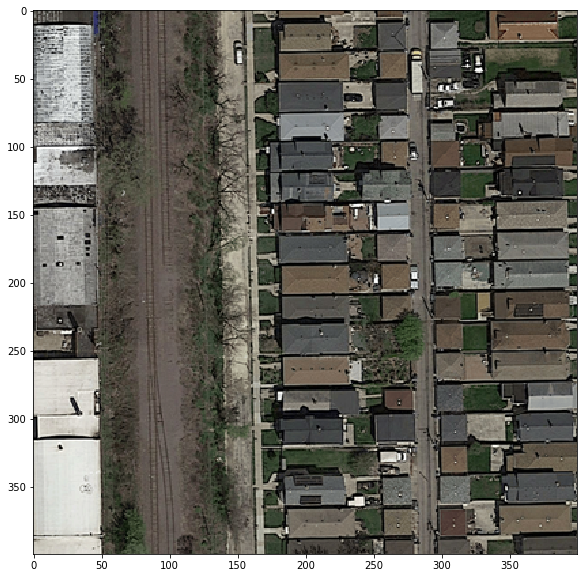

In [19]:
# DISPLAY THE IMAGE
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, label)
cimg = concatenate_images(img_test, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(img_test, predicted_im)

plt.imshow(new_img)


In [117]:
# Post processing

In [118]:
def complete_lines(label,threshold):
    ''' The function controls for each non-road square its neighbors. 
        If they are classified as ROAD with a certain pattern, the considered square is labeled as ROAD.
        
        INPUT: List of patches, Vector of label (SAME ORDER)
        OUTPUT: New patches, New Vector of label'''
    
    # Create a matrix of label
    label = np.array(label)
    label_per_line = int(np.sqrt(label.shape))
    matrix_label = label.reshape((label_per_line, label_per_line),order='F')
    
    # Column with less then 4 zeros are considered as ROAD
    #threshold = 16
    matrix_label[:,np.where(matrix_label.sum(axis=0)>=threshold)[0]] = 1
  
    
    # Rows with less then 4 zeros are considered as ROAD
    #threshold = 16
    matrix_label[np.where(matrix_label.sum(axis=1)>=threshold)[0],:] = 1
  
    # Create the list
    list_label = (matrix_label.T).tolist()
    # Flatten the lists
    label = [y for x in list_label for y in x]
    return label

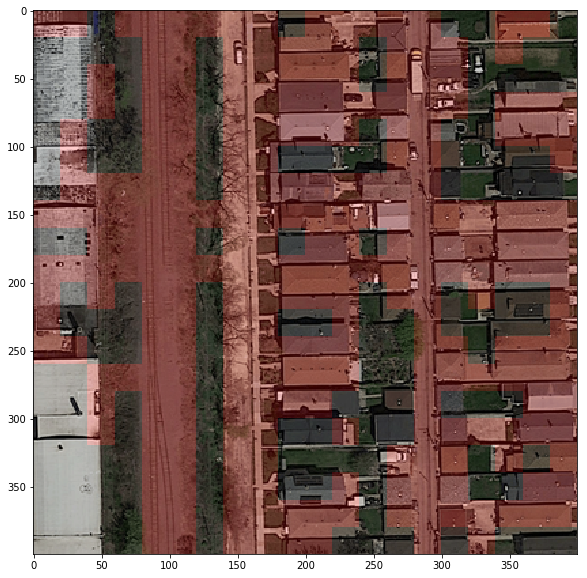

In [119]:
new_label = complete_lines(label,16)

# DISPLAY THE IMAGE
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, new_label)
cimg = concatenate_images(img_test, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(img_test, predicted_im)

plt.imshow(new_img)

In [120]:
def remove_isolated_connected_component(label,size_min):
    
    # Create a matrix of label
    label = np.array(label)
    label_per_line = int(np.sqrt(label.shape))
    matrix_label = label.reshape((label_per_line, label_per_line),order='F')
    
    # now identify the objects and remove those above a threshold
    Zlabeled,Nlabels = ndimage.measurements.label(matrix_label)
    label_size = [(Zlabeled == label).sum() for label in range(Nlabels + 1)]
    
    # now remove the labels
    for label,size in enumerate(label_size):
        if size < size_min:
            matrix_label[Zlabeled == label] = 0
    
    # Create the list
    list_label = (matrix_label.T).tolist()
    # Flatten the lists
    label = [y for x in list_label for y in x]
    
    return label


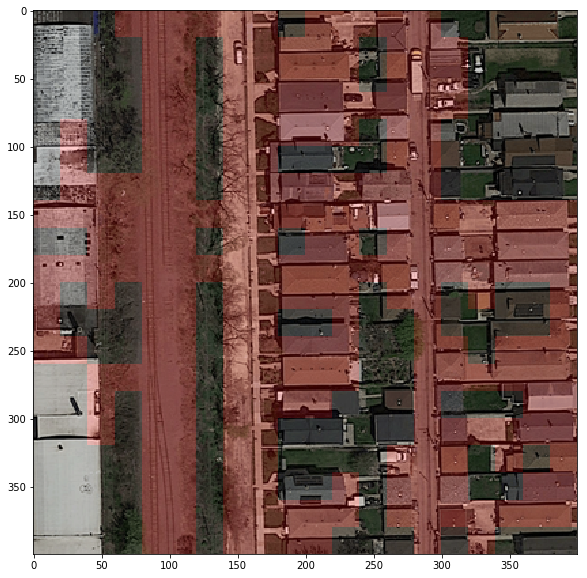

In [121]:
new_label2 = remove_isolated_connected_component(new_label,9)

# DISPLAY THE IMAGE
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, new_label2)
cimg = concatenate_images(img_test, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(img_test, predicted_im)

plt.imshow(new_img)

In [122]:
gt_patches = img_crop(gt_test, patch_size, patch_size)
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
F1 = calcul_F1(Y,new_label2)

In [123]:
print(F1)

0.36303630363036304


In [124]:
def complete_lines_almostfull(label):
    ''' The function controls for each non-road square its neighbors. 
        If they are classified as ROAD with a certain pattern, the considered square is labeled as ROAD.
        
        INPUT: List of labels
        OUTPUT: New list of labels'''
    
    max_zeros = 3
    
    # Create a matrix of label
    label = np.array(label)
    label_per_line = int(np.sqrt(label.shape))
    matrix_label = label.reshape((label_per_line, label_per_line),order='F')
    
    # Fix columns
    rows,columns = matrix_label.shape
    for column in range(columns):
        count = 0
        start = 0
        end = 0
        for row in range(rows):
            if (matrix_label[row,column] == 1) and (start ==0):
                start = 1
            elif (matrix_label[row,column] == 1) and (start ==1) and (count>0):
                end = 1
            elif (matrix_label[row,column] == 0) and (start ==1) and (end==0):
                count = count + 1
            
            if end ==1:
                if count < max_zeros:
                    matrix_label[row-count:row,column] = 1
                start = 1
                end = 0
                count = 0
    
    # Fix rows
    for row in range(rows):
        count = 0
        start = 0
        end = 0
        for column in range(columns):
            if (matrix_label[row,column] == 1) and (start ==0):
                start = 1
            elif (matrix_label[row,column] == 1) and (start ==1) and (count>0):
                end = 1
            elif (matrix_label[row,column] == 0) and (start ==1) and (end==0):
                count = count + 1
            
            if end ==1:
                if count < max_zeros:
                    matrix_label[row,column-count:column] = 1
                start = 1
                end = 0
                count = 0
    
    
    # Create the list
    list_label = (matrix_label.T).tolist()
    # Flatten the lists
    label = [y for x in list_label for y in x]
    
    return label

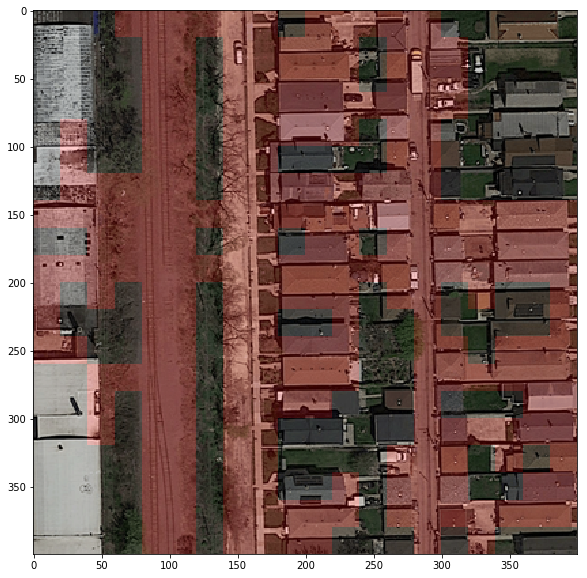

In [125]:
#new_label3 = complete_lines_almostfull(new_label2)

# DISPLAY THE IMAGE
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, new_label2)
cimg = concatenate_images(img_test, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(img_test, predicted_im)

plt.imshow(new_img)

In [181]:
def bootstrap(imgs,size,number):
    '''This function returns a list of list. Each element of the "external" list is a list of randomly 
    sampled images with replacement'''
    
    new_imgs=[]
    array = np.arange(len(imgs))
    for k in range(number):
        b = np.random.choice(array, size, replace=True)
        list_temp = [imgs[i] for i in b]
        new_imgs.append(list_temp)
    
    return new_imgs

In [182]:
#bootstrap imgs
boostrap_imgs = bootstrap(imgs,5,5)

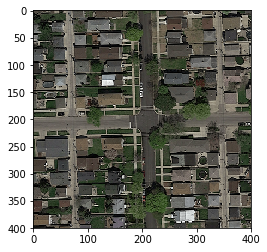

In [21]:
#print(imgs[0])
plt.imshow(imgs[0])

In [64]:
def add_border(imgs,new_size):
    old_size = imgs.shape[0]
    add = new_size-old_size
    new_im = imgs[:add,:,:]
    new_im = new_im[::-1,:,:]
    final_row = np.concatenate((new_im,imgs[:,:]),axis=0)
    new_im = imgs[-add:,:,:]
    new_im = new_im[::-1,:,:]
    final_row = np.concatenate((final_row,new_im[:,:]),axis=0)
    new_im = final_row[:,:add,:]
    new_im = new_im[:,::-1,:]
    final = np.concatenate((new_im,final_row[:,:]),axis=1)
    new_im = final_row[:,-add:,:]
    new_im = new_im[:,::-1,:]
    final = np.concatenate((final,new_im[:,:]),axis=1)
    return final

In [68]:
new_img = add_border(imgs[0],440)

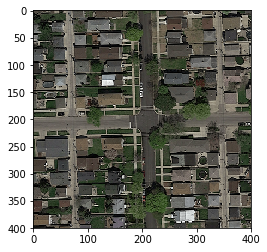

In [69]:
plt.imshow(imgs[0])

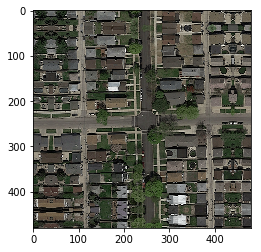

In [70]:
plt.imshow(new_img)

In [85]:
def remove_border(imgs,new_size):
    old_size = imgs.shape[0]
    remove = int((old_size - new_size)/2)
    new_img = imgs[remove:-remove,remove:-remove,:]
    return new_img

In [86]:
resize = remove_border(new_img,400)

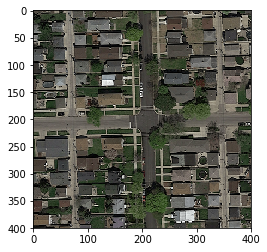

In [87]:
plt.imshow(resize)

In [ ]:
## PER LA PROSSIMA VOLTA:
# 1. FUNZIONI PARAMETRICHE
# 2. PARCHEGGI